# Classification de graphes

In [92]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapely
import networkx as nx
import os
import karateclub as kc
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Construction des graphes

### Prétraitement des données

In [93]:
def preprocessing(gdf, commune, rm_residual_areas=True, object_prop_th=0.20, total_prop_th=0.01):
    assert len(gdf) != 0
    # todo : gérer les nodata
    gdf["total_area"] = gdf.area

    gdf = gdf.clip(commune["geometry"])

    gdf = gdf.drop("Area_Ha", axis="columns")

    gdf = gdf.explode(index_parts=False)
    gdf["object_proportion"] = gdf.area / gdf["total_area"]
    gdf["total_proportion"] = gdf.area / gdf.area.sum()

    if rm_residual_areas is True:
        gdf = gdf[(gdf["object_proportion"] >= object_prop_th) | (gdf["total_proportion"] >= total_prop_th)]

    gdf['Node_ID'] = range(len(gdf))  # pour simplifier la création des graphes
    gdf['Code_18'] = gdf['Code_18'].astype(str)

    return gdf

### Calcul du voisinage

In [94]:
def preprocess_border(border):
    if border.geom_type == "MultiLineString":
        # plusieurs frontières
        border = shapely.ops.linemerge(border)
    return border


def calc_borders(area, neighbors):
    borders_info = {"total_border": [], "greatest_border": [], "nb_borders": []}
    borders = neighbors.geometry.intersection(area.geometry)
    for border in borders:
        border = preprocess_border(border)
        if border.geom_type == "MultiLineString":
            lengths = gpd.GeoSeries(border.geoms).length
            borders_info["total_border"].append(lengths.sum())
            borders_info["greatest_border"].append(max(lengths))
            borders_info["nb_borders"].append(len(lengths))
        else:
            length = border.length
            borders_info["total_border"].append(length)
            borders_info["greatest_border"].append(length)
            borders_info["nb_borders"].append(1)
    return borders_info


def calc_neighbors(gdf):
    neighbors_dict = {"src": [], "dest": [], "total_border": [], "greatest_border": [], "nb_borders": []}

    for index, area in gdf.iterrows():
        neighbors = gdf[gdf.geometry.touches(area.geometry)]
        neighbors = neighbors[~neighbors['Node_ID'].isin(neighbors_dict['src'])]

        dest = neighbors['Node_ID'].tolist()
        src = [area['Node_ID']] * neighbors.shape[0]

        borders = calc_borders(area, neighbors)

        neighbors_dict["src"].extend(src)
        neighbors_dict["dest"].extend(dest)
        neighbors_dict["total_border"].extend(borders["total_border"])
        neighbors_dict["greatest_border"].extend(borders["greatest_border"])
        neighbors_dict["nb_borders"].extend(borders["nb_borders"])

    return neighbors_dict

### Génération des données des graphes

In [95]:
def generate_graph_data(data_path, communes_path):
    graph_properties_dict = {"graph_id": [], "num_nodes": []}
    graph_nodes_dict = {"graph_id": [], "node_id": [], "label": []}
    graph_edges_dict = {"graph_id": [], "src": [], "dest": [], "total_border": [], "greatest_border": [],
                        "nb_borders": []}

    communes = gpd.read_file(communes_path)

    l = len(communes)
    step = int(l * 0.05)
    print(f"Number of instances : {l}")
    i = 1

    for _, commune in communes.iterrows():
        if i % step == 1:
            print(f"{int((i / l) * 100)}%", end="...")

        gdf = preprocessing(gpd.read_file(data_path, mask=commune['geometry']), commune)

        neighbors = calc_neighbors(gdf)

        graph_properties_dict["graph_id"].append(commune['COMM_ID'])
        graph_properties_dict["num_nodes"].append(len(gdf))

        graph_nodes_dict["graph_id"].extend([commune['COMM_ID']] * len(gdf))
        graph_nodes_dict["node_id"].extend(gdf["Node_ID"])
        graph_nodes_dict["label"].extend(gdf["Code_18"])

        graph_edges_dict["src"].extend(neighbors["src"])
        graph_edges_dict["dest"].extend(neighbors["dest"])
        graph_edges_dict["total_border"].extend(neighbors["total_border"])
        graph_edges_dict["greatest_border"].extend(neighbors["greatest_border"])
        graph_edges_dict["nb_borders"].extend(neighbors["nb_borders"])
        graph_edges_dict["graph_id"].extend([commune['COMM_ID']] * len(neighbors["src"]))

        i = i + 1

    print("100%")

    graph_properties_df = pd.DataFrame(graph_properties_dict)
    graph_nodes_df = pd.DataFrame(graph_nodes_dict)
    graph_edges_df = pd.DataFrame(graph_edges_dict)

    return graph_properties_df, graph_nodes_df, graph_edges_df

In [96]:
clc_path = "../data/raw_data/clc/u2018_clc2018_v2020_20u1_geoPackage/DATA/U2018_CLC2018_V2020_20u1.gpkg"
communes_dir = "../data/communes"
communes_path = os.path.join(communes_dir, "communes.gpkg")

In [97]:
graph_properties, graph_nodes, graph_edges = generate_graph_data(clc_path, communes_path)

graph_properties["label"] = graph_properties["graph_id"].str[:2].astype('category').cat.codes

graph_properties.to_csv(os.path.join(communes_dir, "graph_properties.csv"))
graph_nodes.to_csv(os.path.join(communes_dir, "graph_nodes.csv"))
graph_edges.to_csv(os.path.join(communes_dir, "graph_edges.csv"))

Number of instances : 30600
0%...5%...10%...15%...20%...25%...30%...35%...40%...45%...50%...55%...60%...65%...70%...75%...80%...85%...90%...95%...100%


### Quelques statistiques

In [110]:
graph_properties = pd.read_csv(os.path.join(communes_dir, "graph_properties.csv"))
graph_nodes = pd.read_csv(os.path.join(communes_dir, "graph_nodes.csv"))
graph_edges = pd.read_csv(os.path.join(communes_dir, "graph_edges.csv"))

In [98]:
def describe_graphs_data(properties, nodes, edges):
    # nombre d'instances
    instances = len(properties)
    # nombre de classes
    classes = len(properties['label'].astype('category').cat.categories)
    # nombre de noeuds en moyenne
    nodes_groups_sizes = nodes.groupby('graph_id').size()
    min_nodes = np.round(nodes_groups_sizes.min(), 2)
    mean_nodes = np.round(nodes_groups_sizes.mean(), 2)
    max_nodes = np.round(nodes_groups_sizes.max(), 2)
    # nombre d'arcs en moyenne
    edges_groups_sizes = edges.groupby('graph_id').size()
    min_edges = np.round(edges_groups_sizes.min(), 2)
    mean_edges = np.round(edges_groups_sizes.mean(), 2)
    max_edges = np.round(edges_groups_sizes.max(), 2)
    # nombre de labels distincts
    labels = len(nodes['label'].astype('category').cat.categories)
    print(f"# instances : {instances}")
    print(f"# classes : {classes}")
    print(f"# nodes (min.) : {min_nodes}")
    print(f"# nodes (avg.) : {mean_nodes}")
    print(f"# nodes (max.) : {max_nodes}")
    print(f"# edges (min.) : {min_edges}")
    print(f"# edges (avg.) : {mean_edges}")
    print(f"# edges (max.) : {max_edges}")
    print(f"# distinct node labels : {labels}")

In [99]:
describe_graphs_data(graph_properties, graph_nodes, graph_edges)

# instances : 30600
# classes : 17
# nodes (min.) : 1
# nodes (avg.) : 20.64
# nodes (max.) : 549
# edges (min.) : 1
# edges (avg.) : 38.68
# edges (max.) : 1323
# distinct node labels : 44


### Création des graphes

In [80]:
# NetworkX dataset
class NxClassDataset():
    def __init__(self, properties, nodes, edges):
        self.properties = properties
        self.nodes = nodes
        self.edges = edges
        self.graphs = []
        self.labels = []
        self.labels_str = []
        self.ids = []
        self.process()

    def process(self):
        # Create a graph for each graph ID from the edges table.
        # First process the properties table into two dictionaries with graph IDs as keys.
        # The label and number of nodes are values.
        label_dict = {}
        for _, row in self.properties.iterrows():
            label_dict[row['graph_id']] = row['label']

        # Group by graph IDs
        edges_group = self.edges.groupby('graph_id')
        nodes_group = self.nodes.groupby('graph_id')

        # For each graph ID...
        for graph_id in edges_group.groups:
            edges_of_id = edges_group.get_group(graph_id)
            nodes_of_id = nodes_group.get_group(graph_id)
            label = label_dict[graph_id]

            g = nx.Graph(label=label, id=graph_id)
            for _, row in nodes_of_id.iterrows():
                g.add_node(row['node_id'], feature=str(row['label']))
            for _, row in edges_of_id.iterrows():
                g.add_edge(row['src'], row['dest'], total_border=row['total_border'],
                           greatest_border=row['greatest_border'],
                           nb_borders=row['nb_borders'])

            self.graphs.append(g)
            self.labels.append(label)
            self.labels_str.append(graph_id[:2])
            self.ids.append(graph_id)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i], self.ids[i]

    def get_graphs(self):
        return self.graphs

    def get_labels(self):
        return self.labels

    def get_labels_str(self):
        return self.labels_str

    def get_ids(self):
        return self.ids

In [81]:
communes_nx_dataset = NxClassDataset(graph_properties, graph_nodes, graph_edges)

### Visualisation des graphes

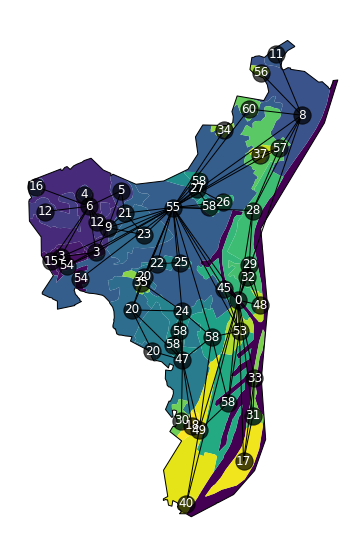

In [84]:
def draw_map_graph(nx_graph, gdf, column=None, legend=False, ax=None):
    pos = {}
    points = gdf.representative_point()
    for i in range(len(gdf)):
        area = gdf.iloc[i]
        point = points.iloc[i]
        pos[area['Node_ID']] = (point.x, point.y)

    gdf.plot(column, legend=legend, ax=ax)
    labels = {k:gdf.index.values[k] for k in range(len(gdf))}
    nx.draw(nx_graph, pos=pos, with_labels=True, ax=ax, node_color=[(0, 0, 0, 0.7)], font_color="white", labels=labels)


g_nx, g_label, g_id = communes_nx_dataset[0]
f, ax = plt.subplots(figsize=(10, 10))
communes = gpd.read_file(communes_path)
commune = communes[communes['COMM_ID'] == g_id]
gdf = preprocessing(gpd.read_file(clc_path, mask=commune['geometry']), commune)
gdf.dissolve().exterior.plot(ax=ax, color="black", linewidth=1)
draw_map_graph(g_nx, gdf=gdf, column=np.array(range(len(gdf))), ax=ax)
# plt.title(f"{g_id} - Superposition de la carte et du graphe")
plt.show()

## Un premier problème simple : un pays par région d'Europe

Prenons un pays représentant par région d'Europe, ce seront les classes à prédire.

<br />
<img src="../assets/europe-regions.png" alt="drawing" width="400"/>

### Création de l'échantillon

In [149]:
selected_countries = ['ES', 'DE', 'IE', 'RO']


In [150]:
# création d'un échantillon 2040 instances
groups = graph_properties[graph_properties['graph_id'].str[:2].isin(selected_countries)].sample(frac=1).groupby('label')
min_graph_count = min(510, groups.size().sort_values().iloc[0])
ech_properties = groups.nth(list(range(min_graph_count)))
ech_properties = ech_properties.reset_index(level=0)
ech_properties['label'] = ech_properties['label'].astype('category').cat.codes

In [151]:
ech_nodes = graph_nodes[graph_nodes['graph_id'].isin(ech_properties['graph_id'])]
ech_edges = graph_edges[graph_edges['graph_id'].isin(ech_properties['graph_id'])]

In [152]:
describe_graphs_data(ech_properties, ech_nodes, ech_edges)

# instances : 2040
# classes : 4
# nodes (min.) : 1
# nodes (avg.) : 31.23
# nodes (max.) : 597
# edges (min.) : 1
# edges (avg.) : 57.74
# edges (max.) : 1410
# distinct node labels : 43


In [153]:
communes_nx_dataset = NxClassDataset(properties=ech_properties,
                                     nodes=ech_nodes,
                                     edges=ech_edges)

In [154]:
graphs = communes_nx_dataset.get_graphs()
labels = np.array(communes_nx_dataset.get_labels())
labels_str = communes_nx_dataset.get_labels_str()

### Embedding

karate club: https://karateclub.readthedocs.io/en/latest/index.html

In [155]:
def g2v_embedding(graphs, **embedding_params):
    graph2vec = kc.Graph2Vec(attributed=True, **embedding_params)
    graph2vec.fit(graphs)
    return graph2vec.get_embedding()

In [156]:
# graph2vec = kc.Graph2Vec(wl_iterations=4, dimensions=1024, epochs=400, min_count=2, attributed=True)
g2v_dataset = g2v_embedding(graphs, epochs=100)

### Classification

In [157]:
def make_model(input_shape, n_classes):
    model = keras.models.Sequential([
        keras.layers.Input(input_shape),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.005)),
        keras.layers.Dropout(rate=0.1),
        keras.layers.Dense(n_classes, activation='softmax')
    ])
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=10000,
        decay_rate=0.9)
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=lr_schedule),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

In [158]:
def plot_history(history):
    training_loss = history.history['loss']
    training_acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']

    f = plt.figure(figsize=(10, 4))
    ax = plt.subplot(121)
    plt.plot(training_loss, label="Train loss")
    plt.plot(val_loss, label="Validation loss")
    plt.legend()
    ax = plt.subplot(122)
    plt.plot(training_acc, label="Train accuracy")
    plt.plot(val_acc, label="Validation accuracy")
    plt.legend()
    plt.show()

In [159]:
def test_model(data, labels, labels_str=None):
    X_train, X_test, y_train, y_test = train_test_split(data, np.array(labels), test_size=0.2)
    model = make_model(X_train[0].shape, len(np.unique(labels)))
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=1000, validation_split=0.2,
                    callbacks=[early_stopping_cb])

    y_pred = model.predict(X_test).argmax(axis=-1)

    class_report = classification_report(y_test, y_pred, target_names=labels_str)
    cf_matrix = confusion_matrix(y_test, y_pred)

    return class_report, cf_matrix, history

In [160]:
class_report, cf_matrix, history = test_model(g2v_dataset, labels, np.unique(labels_str))

Epoch 1/1000
41/41 [==============================] - 0s 4ms/step - loss: 1.5320 - accuracy: 0.3646 - val_loss: 1.4668 - val_accuracy: 0.6471
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 1.4305 - accuracy: 0.6354 - val_loss: 1.3564 - val_accuracy: 0.8080
Epoch 3/1000
41/41 [==============================] - 0s 2ms/step - loss: 1.3173 - accuracy: 0.7701 - val_loss: 1.2372 - val_accuracy: 0.8669
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 1.2017 - accuracy: 0.8142 - val_loss: 1.1158 - val_accuracy: 0.8947
Epoch 5/1000
41/41 [==============================] - 0s 2ms/step - loss: 1.0902 - accuracy: 0.8406 - val_loss: 0.9990 - val_accuracy: 0.9009
Epoch 6/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.9882 - accuracy: 0.8676 - val_loss: 0.8904 - val_accuracy: 0.9133
Epoch 7/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.8953 - accuracy: 0.8653 - val_loss: 0.7989 - val_accuracy: 0.9133
Epoch 

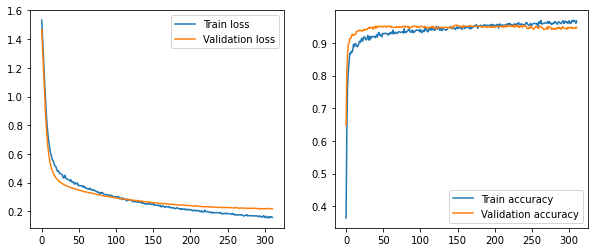

In [161]:
plot_history(history)

In [162]:
print("Classification report")
print(class_report)

Classification report
              precision    recall  f1-score   support

          DE       0.87      0.84      0.85       108
          ES       0.98      0.97      0.97        90
          IE       0.89      0.95      0.92        98
          RO       0.94      0.92      0.93       108

    accuracy                           0.92       404
   macro avg       0.92      0.92      0.92       404
weighted avg       0.92      0.92      0.92       404



Confusion matrix


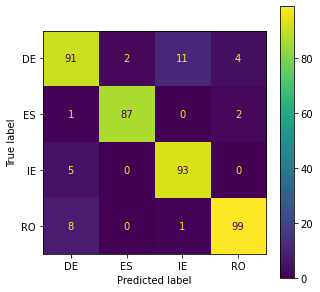

In [163]:
print("Confusion matrix")
cf_display = ConfusionMatrixDisplay(cf_matrix, display_labels=np.unique(labels_str))
f, ax = plt.subplots(figsize=(5, 5))
cf_display.plot(ax=ax)
plt.show()

## Un problème plus difficile : 17 pays d'Europe

### Création de l'échantillon


In [139]:
# création d'un échantillon 2040 instances
groups = graph_properties.sample(frac=1).groupby('label')
min_graph_count = min(120,groups.size().sort_values().iloc[0])
ech_properties = groups.nth(list(range(min_graph_count)))
ech_properties = ech_properties.reset_index(level=0)
ech_properties['label'] = ech_properties['label'].astype('category').cat.codes

In [140]:
ech_nodes = graph_nodes[graph_nodes['graph_id'].isin(ech_properties['graph_id'])]
ech_edges = graph_edges[graph_edges['graph_id'].isin(ech_properties['graph_id'])]

In [141]:
describe_graphs_data(ech_properties, ech_nodes, ech_edges)

# instances : 2040
# classes : 17
# nodes (min.) : 1
# nodes (avg.) : 24.56
# nodes (max.) : 407
# edges (min.) : 1
# edges (avg.) : 44.16
# edges (max.) : 883
# distinct node labels : 44


In [142]:
communes_nx_dataset = NxClassDataset(properties=ech_properties,
                                     nodes=ech_nodes,
                                     edges=ech_edges)

In [143]:
graphs = communes_nx_dataset.get_graphs()
labels = np.array(communes_nx_dataset.get_labels())
labels_str = np.array(communes_nx_dataset.get_labels_str())

### Embedding


In [144]:
g2v_dataset = g2v_embedding(graphs, epochs=100)

### Classification

In [145]:
class_report, cf_matrix, history = test_model(g2v_dataset, labels, np.unique(labels_str))

Epoch 1/1000
41/41 [==============================] - 0s 4ms/step - loss: 3.0570 - accuracy: 0.0416 - val_loss: 3.0393 - val_accuracy: 0.0492
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 3.0326 - accuracy: 0.0570 - val_loss: 3.0219 - val_accuracy: 0.0646
Epoch 3/1000
41/41 [==============================] - 0s 2ms/step - loss: 3.0168 - accuracy: 0.0624 - val_loss: 3.0068 - val_accuracy: 0.0923
Epoch 4/1000
41/41 [==============================] - 0s 2ms/step - loss: 2.9999 - accuracy: 0.0770 - val_loss: 2.9934 - val_accuracy: 0.1077
Epoch 5/1000
41/41 [==============================] - 0s 2ms/step - loss: 2.9846 - accuracy: 0.0978 - val_loss: 2.9798 - val_accuracy: 0.1138
Epoch 6/1000
41/41 [==============================] - 0s 2ms/step - loss: 2.9696 - accuracy: 0.1055 - val_loss: 2.9657 - val_accuracy: 0.1262
Epoch 7/1000
41/41 [==============================] - 0s 2ms/step - loss: 2.9550 - accuracy: 0.1085 - val_loss: 2.9511 - val_accuracy: 0.1385
Epoch 

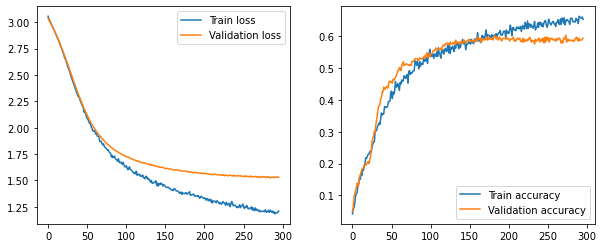

In [146]:
plot_history(history)

In [147]:
print("Classification report")
print(class_report)

Classification report
              precision    recall  f1-score   support

          AT       0.61      0.74      0.67        23
          BG       0.50      0.58      0.54        24
          CH       0.43      0.36      0.39        28
          CZ       0.38      0.36      0.37        25
          DE       0.73      0.52      0.60        31
          DK       0.39      0.79      0.53        19
          ES       0.65      0.68      0.67        22
          FR       0.43      0.30      0.35        20
          HU       0.46      0.52      0.49        21
          IE       0.61      0.61      0.61        18
          IT       0.23      0.32      0.27        19
          MK       0.76      0.55      0.64        29
          PL       0.70      0.80      0.74        20
          PT       0.84      0.76      0.80        34
          RO       0.68      0.62      0.65        24
          SI       0.52      0.70      0.60        20
          SK       0.50      0.24      0.33        29

    

Confusion matrix


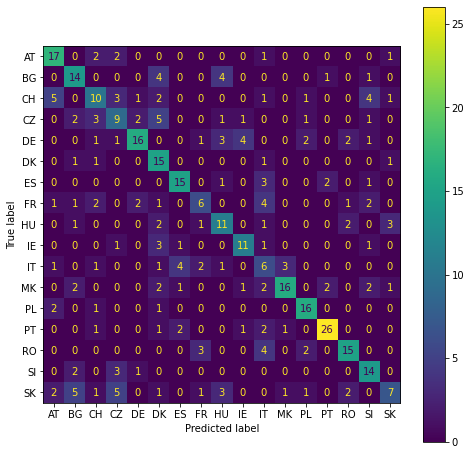

In [148]:
print("Confusion matrix")
cf_display = ConfusionMatrixDisplay(cf_matrix, display_labels=np.unique(labels_str))
f, ax = plt.subplots(figsize=(8, 8))
cf_display.plot(ax=ax)
plt.show()

On remarque qu'il y a des confusions entre les pays de même région, en particulier les pays de l'est.

La France semble très difficile à identifier, ce qui semble relativement normal étant donné sa diversité.


Possibilités :

- regrouper les pays trop proches (notamment les pays de l'Est)
- faire une classification par région

### Hyperparameters tuning

https://colab.research.google.com/drive/1dTVFtliuFPoOu4hVqlOVYqVD899qfA9K?usp=sharing